# Latency analysis

In [1]:
recording_file = "2020-07-16T16-40-18"

In [2]:
import os

import pandas as pd
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from ptinsight.common.latency import calculate_latencies

sb.set(
    style="white",
    font_scale=1.6,
    rc={
        'lines.linewidth': 1.2,
        'axes.titleweight': 'bold',
    }
)

In [3]:
def add_time(data):
    """Add time column starting at 0 s based on the first timestamp"""
    data.sort_values("ingress_ingestion_timestamp", inplace=True)
    data.reset_index(inplace=True)
    data["t"] = (data["ingress_ingestion_timestamp"] - data["ingress_ingestion_timestamp"][0]) / 1000
    
def select_job(job):
    """Get all rows for a specific job"""
    return data[data["job"] == job]
    
def format(axs=None, space_factor=1):
    """Format the plot using the common style"""
    if axs is None:
        axs = [plt.gca()]
    for ax in axs:
        ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())

        ax.grid(b=True, which='major', linewidth=1.0)
        ax.grid(b=True, which='minor', linewidth=0.5, linestyle='-.')
    
    plt.tight_layout(0.1, .4*space_factor, .4*space_factor)
    
def save(name, format="png"):
    """Save the plot to the plots folder"""
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f'plots/plot_{name}.{format}')

## Preprocessing

In [4]:
data = pd.read_csv(f"recordings/{recording_file}.csv")
add_time(data)
calculate_latencies(data)

jobs = pd.unique(data["job"])
n_jobs = len(jobs)
latency_cols = [col for col in data if col.startswith("latency")]
latency_cols_no_e2e = [col for col in latency_cols if not "end_to_end" in col]

## Descriptive statistics of latencies per job

In [5]:
for job in jobs:
    display(Markdown(f"#### Job: {job}"))
    display(select_job(job)[latency_cols].describe())

#### Job: emergency-stop-table

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,7206.000000,7206.000000,7206.000000,7206.000000
mean,1828.327644,34.065640,1759.487649,34.774355
std,550.234742,50.583076,552.212599,68.060902
min,892.000000,3.000000,698.000000,1.000000
25%,1320.250000,12.000000,1265.000000,4.000000
50%,1682.000000,18.000000,1556.000000,9.000000
75%,2279.000000,33.000000,2231.000000,22.000000
max,4340.000000,518.000000,4323.000000,771.000000


#### Job: emergency-stop-streaming

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,4461.000000,4461.000000,4461.000000,4461.000000
mean,6112.321901,32.960995,6051.680565,27.680341
std,5161.682099,49.210778,5157.029127,53.790447
min,1049.000000,3.000000,820.000000,1.000000
25%,2248.000000,11.000000,2201.000000,5.000000
50%,3141.000000,18.000000,3092.000000,10.000000
75%,9600.000000,32.000000,9498.000000,21.000000
max,29747.000000,518.000000,29695.000000,791.000000


#### Job: delay-statistics

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,7200.000000,7200.000000,7200.000000,7200.000000
mean,5021.171667,29.260139,4856.086111,135.825417
std,1642.407051,48.322598,1663.534745,103.989358
min,1339.000000,2.000000,1190.000000,4.000000
25%,3709.750000,10.000000,3514.000000,61.000000
50%,5106.500000,16.000000,4859.000000,108.000000
75%,6285.250000,26.000000,6163.250000,174.000000
max,10265.000000,593.000000,10154.000000,782.000000


#### Job: vehicle-count

,latency_end_to_end,latency_ingest_to_processing,latency_processing,latency_processing_to_ui
count,10920.000000,10920.000000,10920.000000,10920.000000
mean,4410.799725,34.299542,4182.037363,194.462821
std,1483.361100,50.012111,1478.601127,100.052241
min,1234.000000,3.000000,1121.000000,4.000000
25%,3251.000000,12.000000,3046.000000,118.000000
50%,4485.500000,19.000000,4280.000000,187.000000
75%,5629.000000,33.000000,5395.000000,257.000000
max,8554.000000,559.000000,8183.000000,728.000000


## Latency distribution per job

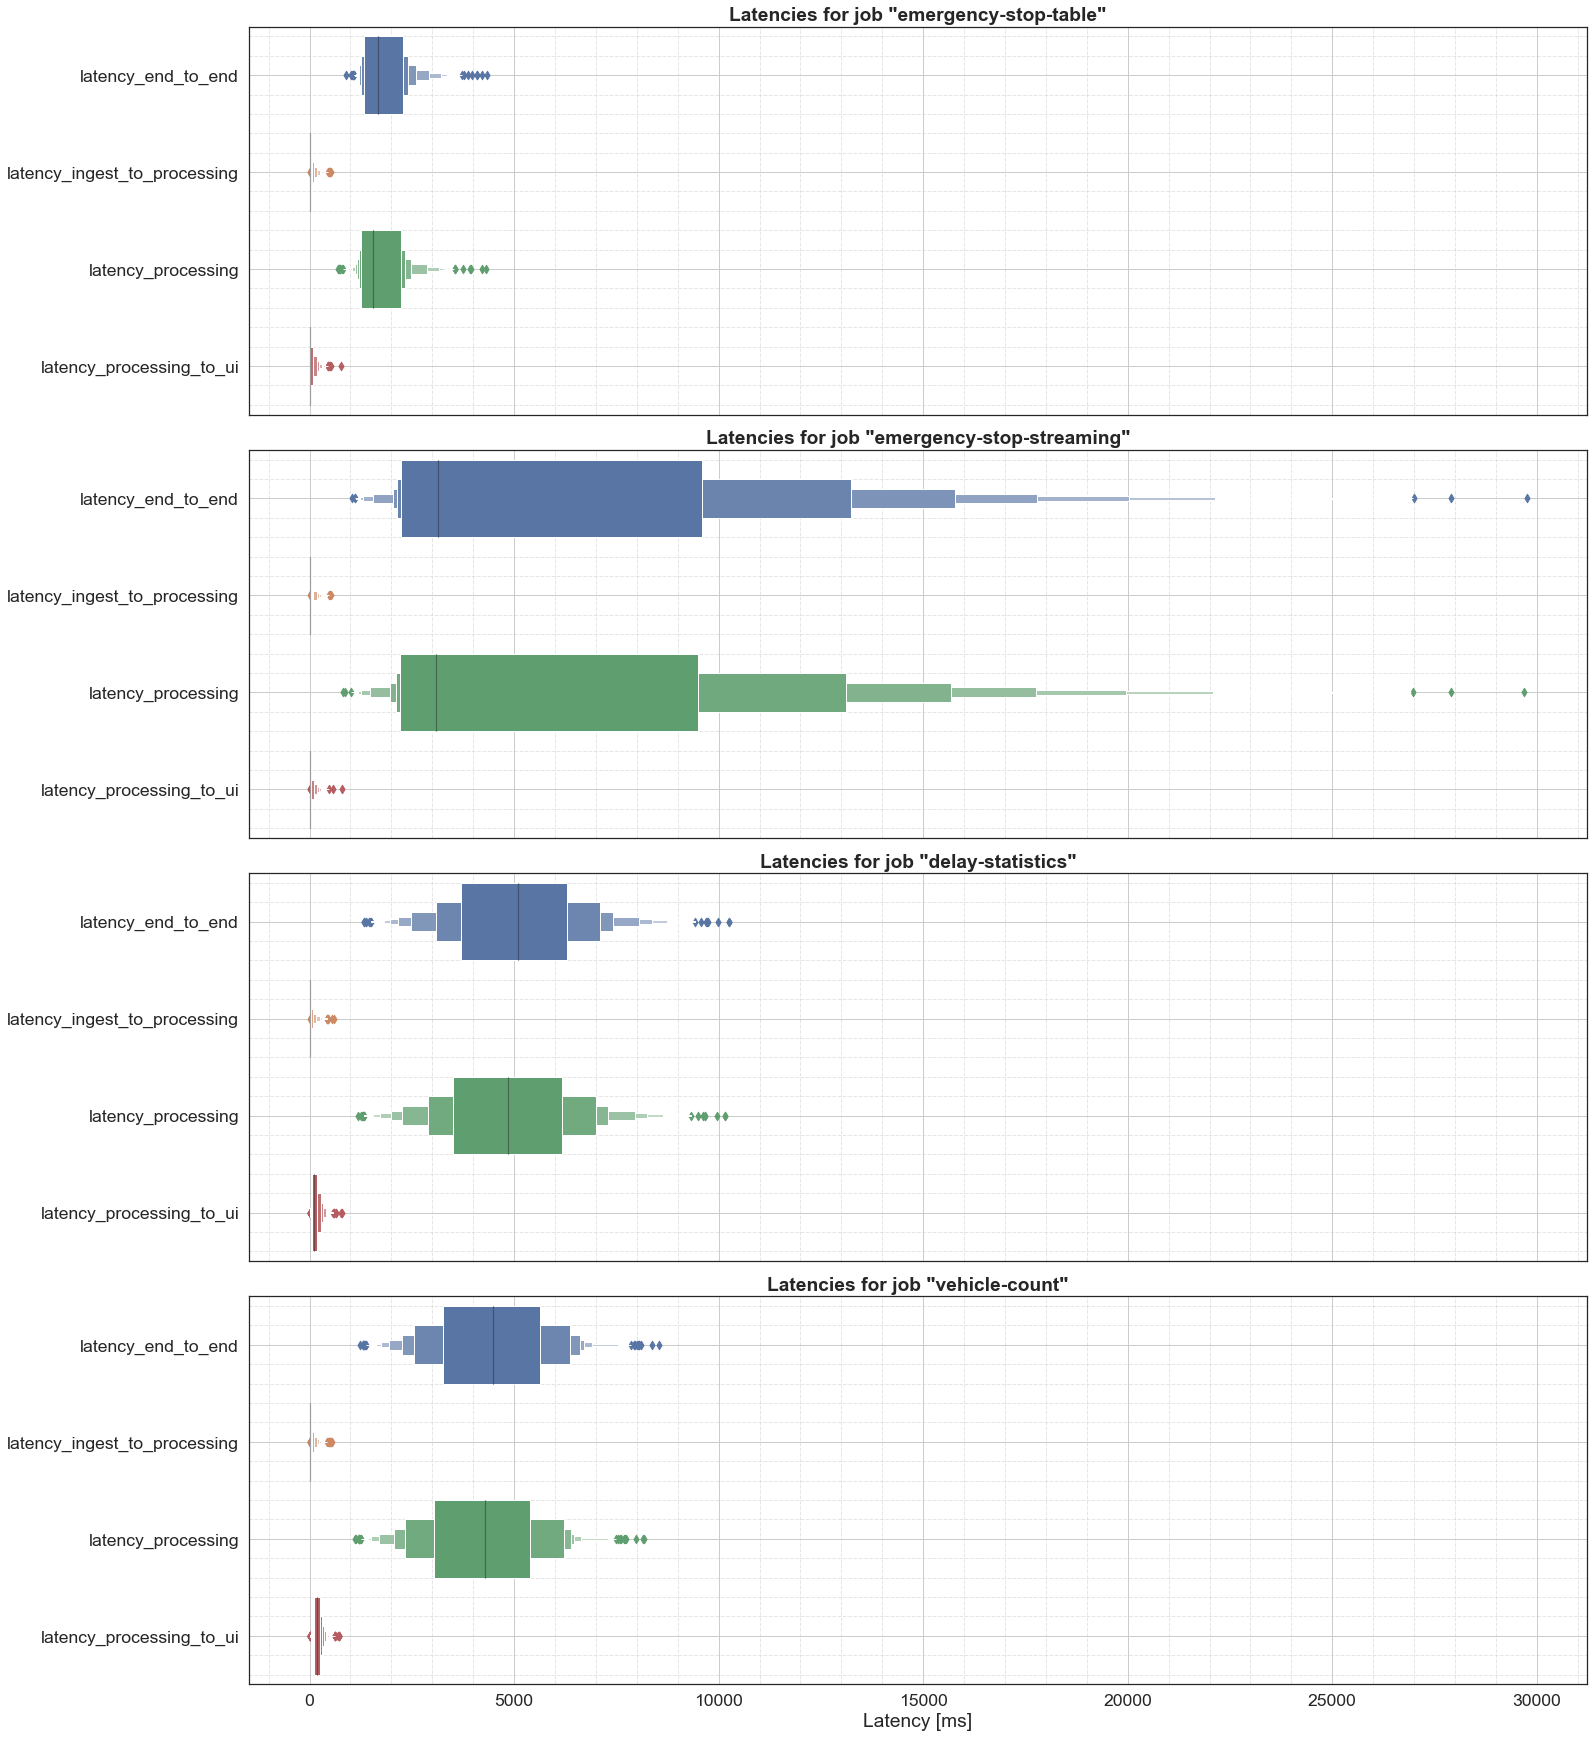

In [6]:
def plot_latency_distribution():
    _, axs = plt.subplots(n_jobs, 1, sharex=True, figsize=[22, 6*n_jobs])
    
    for i, job in enumerate(jobs):
        ax = axs[i]
        
        sb.boxenplot(data=select_job(job)[latency_cols], orient="h", ax=ax)
        
        ax.set_title(f"Latencies for job \"{job}\"")
        if i+1 == len(jobs):
            ax.set_xlabel("Latency [ms]")
        
    format(axs, space_factor=2)
    save("latency_distribution")
    
plot_latency_distribution()

## Latency over time per job

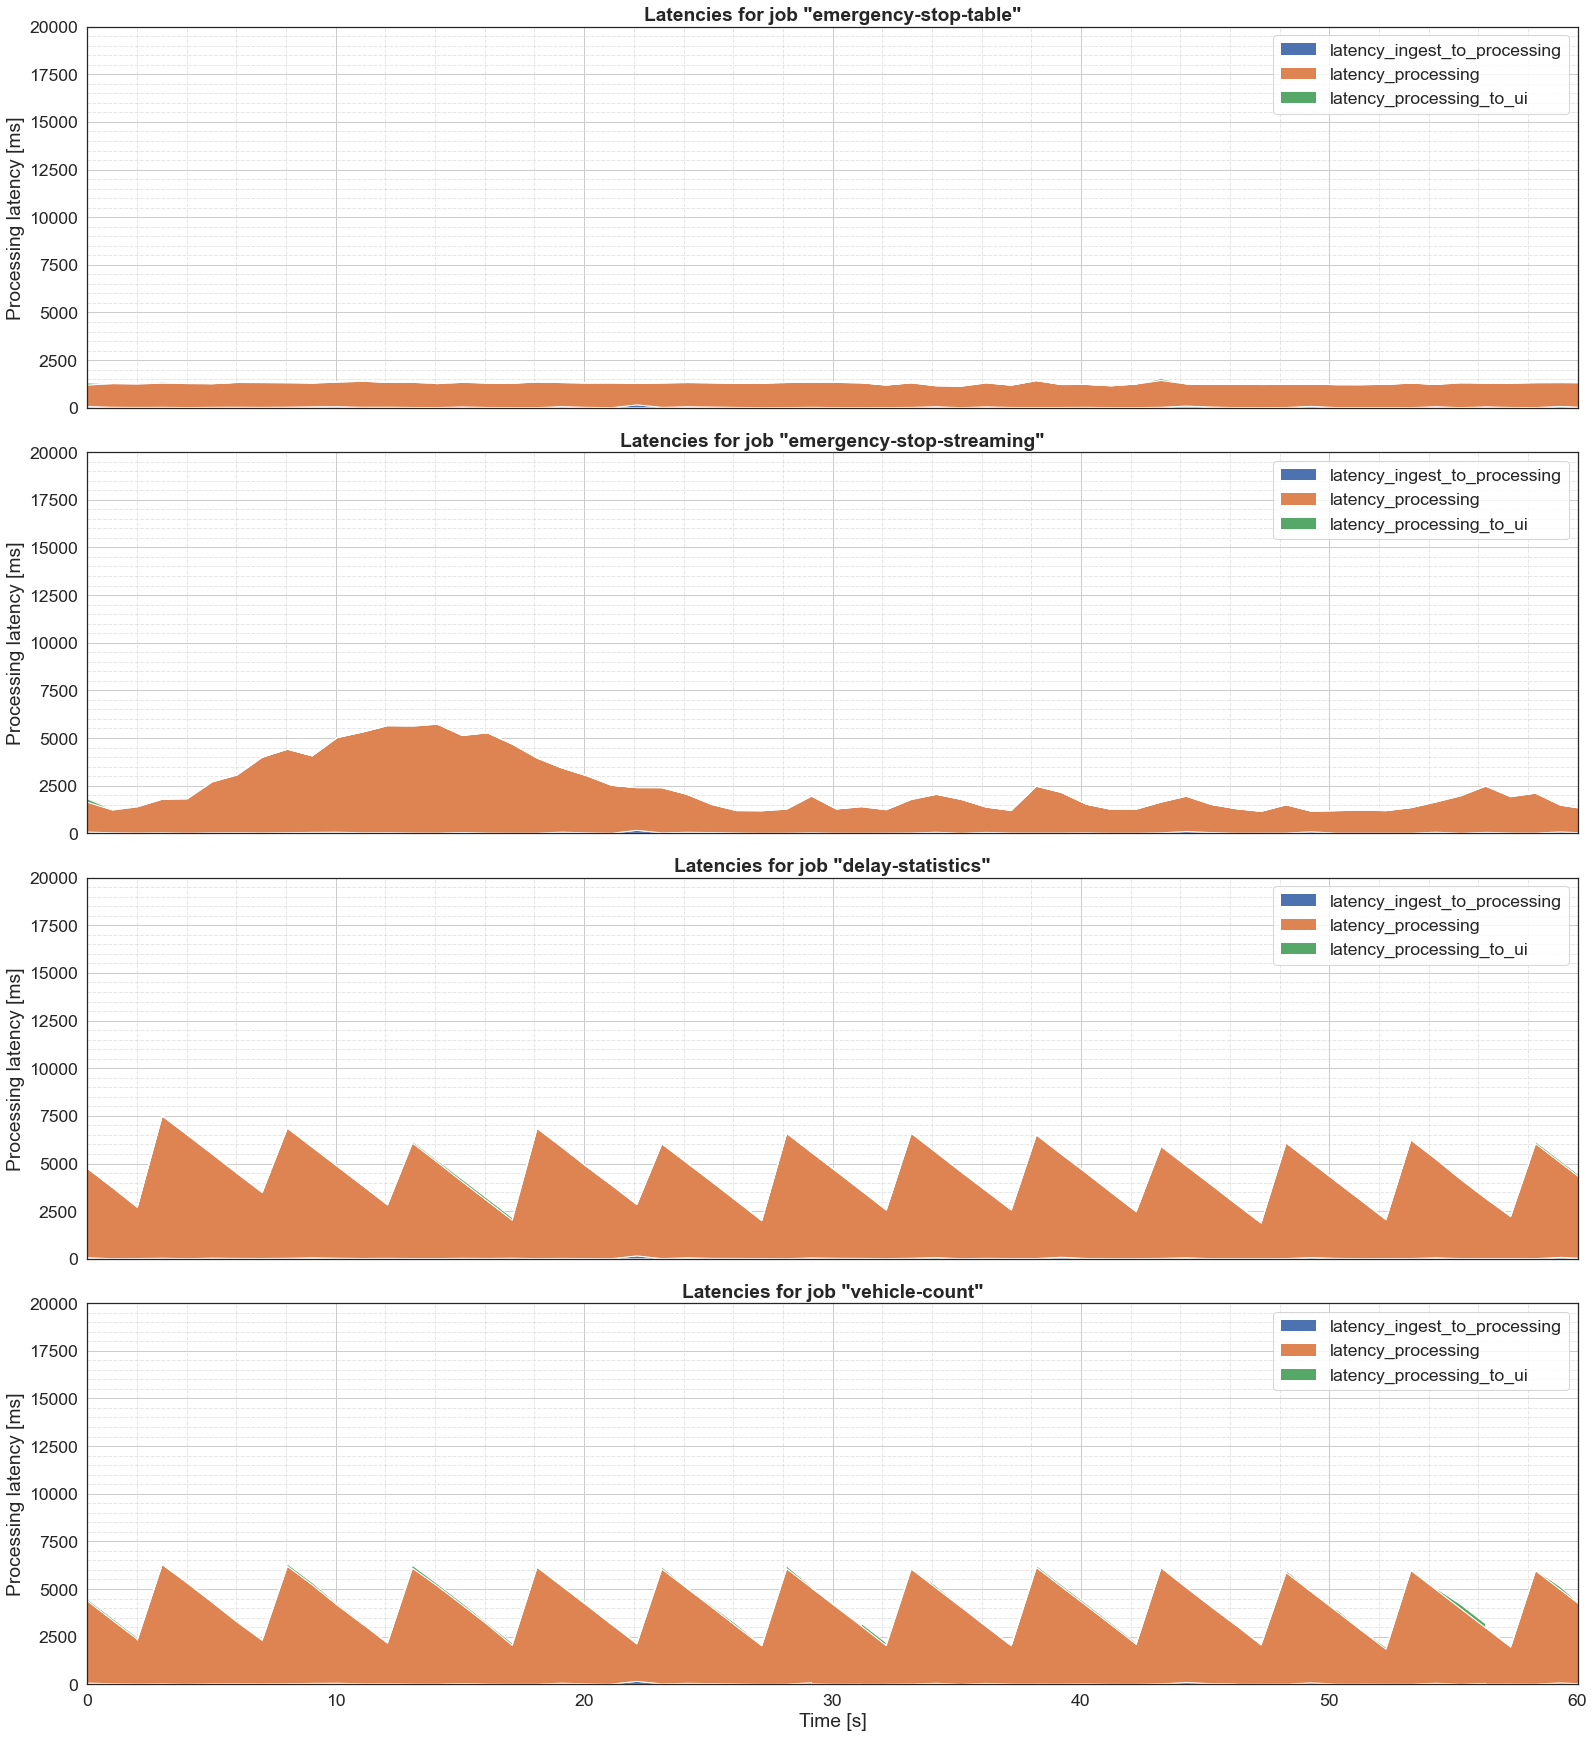

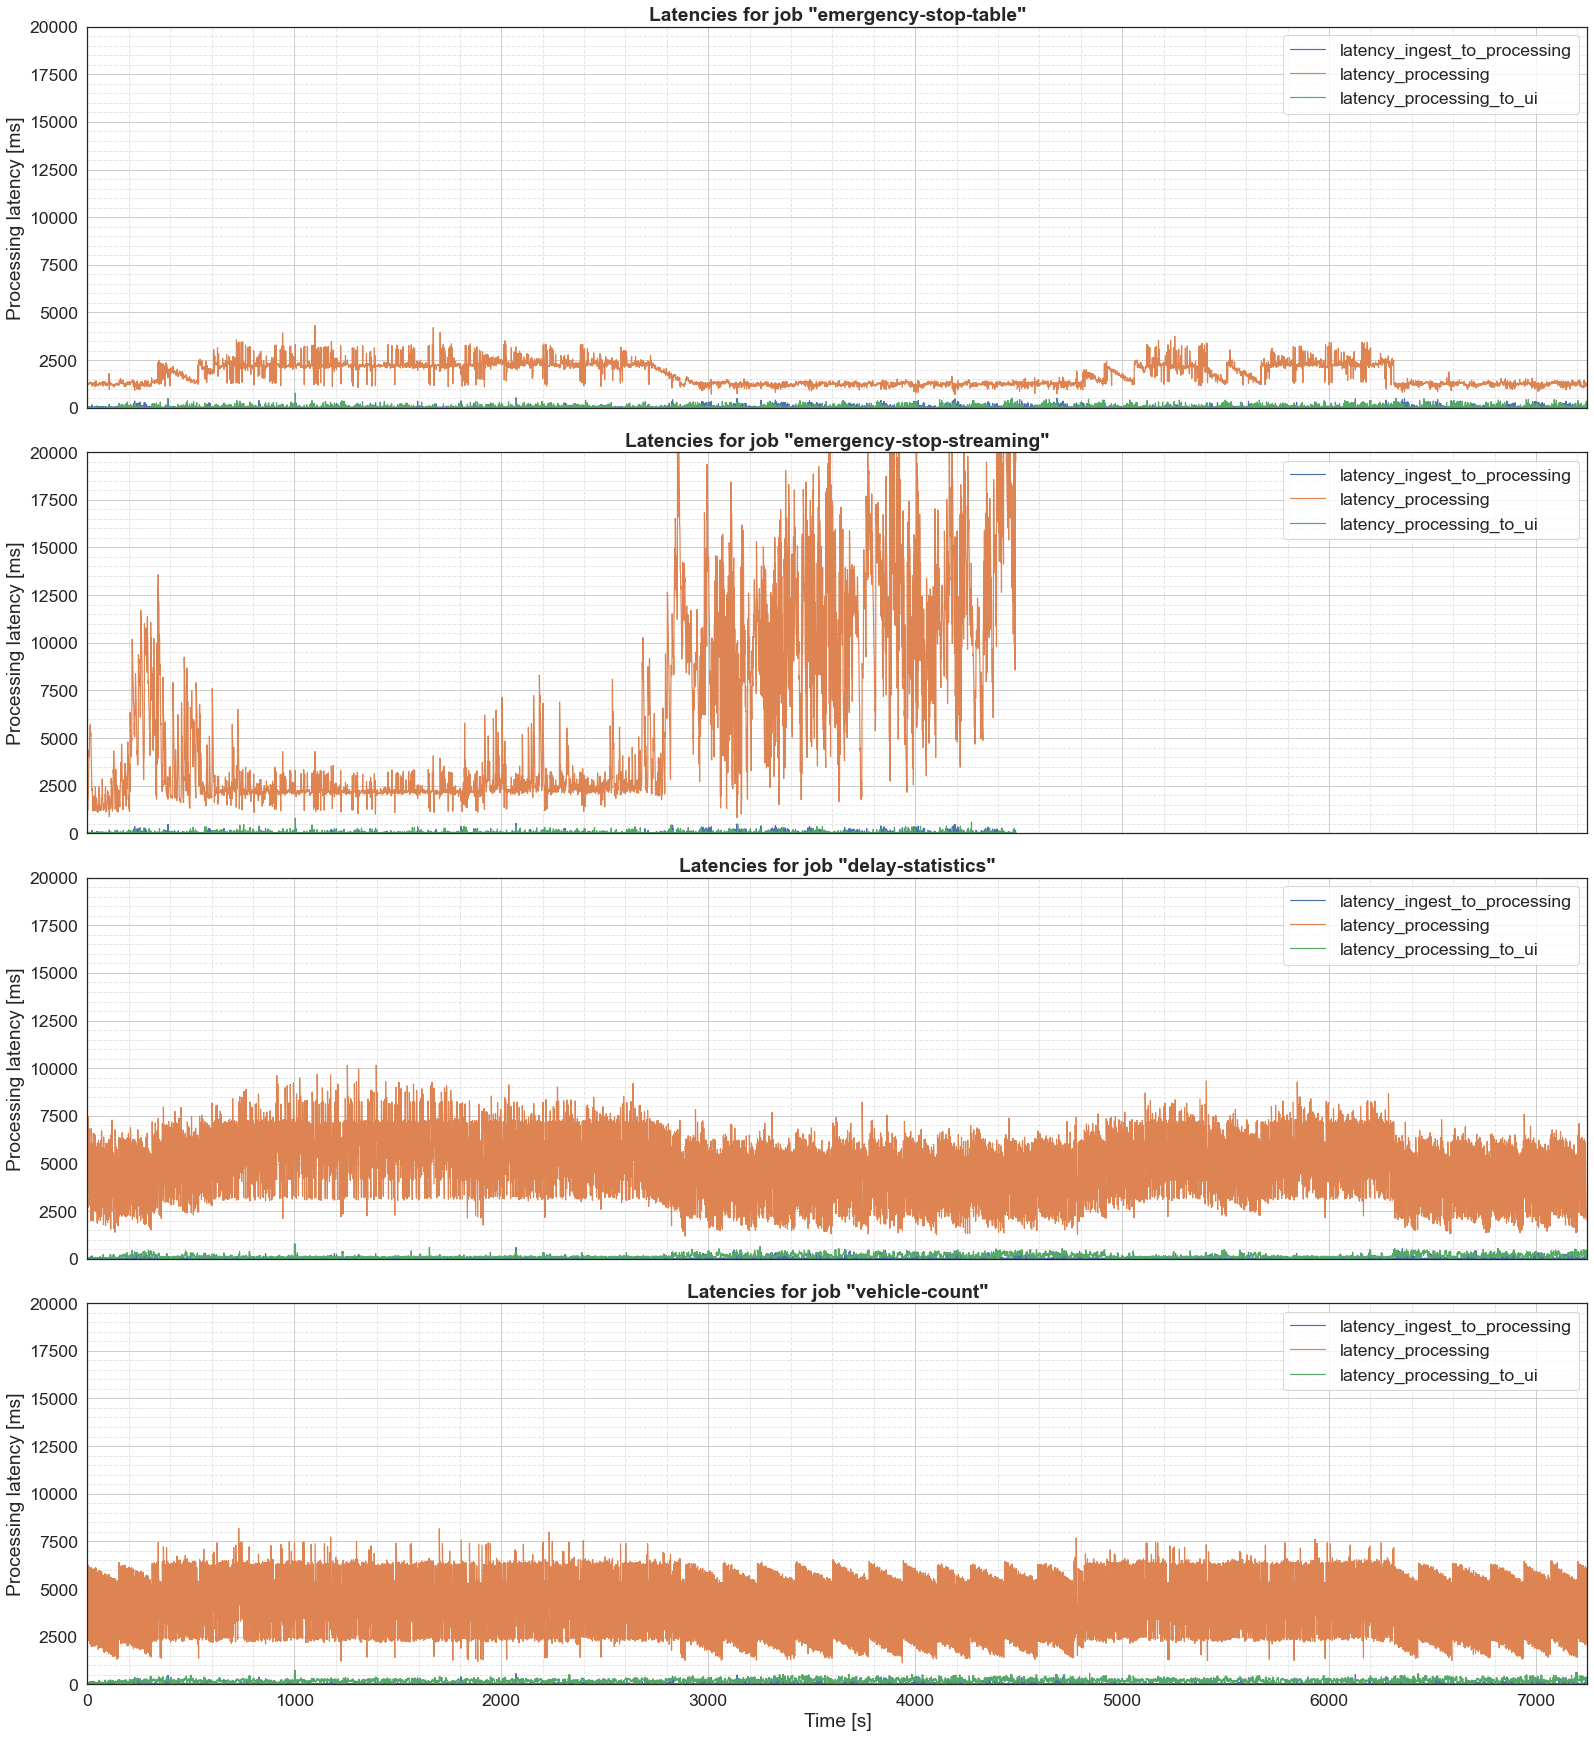

In [7]:
def plot_latency_over_time():
    max_latency = min(20000, data[latency_cols_no_e2e].max().max())
    for max_t in [60, int(data["t"].max())]:
        _, axs = plt.subplots(n_jobs, 1, sharex=True, figsize=[22, 6*n_jobs])
        
        for i, job in enumerate(jobs):
            job_data = select_job(job)
            ax = axs[i]
            
            if max_t <= 120:
                ax.stackplot(job_data["t"], job_data[latency_cols_no_e2e].T, labels=latency_cols_no_e2e)
            else:
                # Stack plot is weird when there are lots of samples, therefore use regular lineplot
                for col in latency_cols_no_e2e:
                    ax.plot(job_data["t"], job_data[col], label=col)
            
            ax.set_xlim([0, max_t])
            ax.set_ylim([0, max_latency])
            ax.set_ylabel("Processing latency [ms]")
            ax.set_title(f"Latencies for job \"{job}\"")
            ax.legend()
            if i+1 == len(jobs):
                ax.set_xlabel("Time [s]")
        
        format(axs, space_factor=2)
        save(f"latency_trend_{max_t}")
    
plot_latency_over_time()

### Observations

After t=3000, vehicle count and delay statistics have a more regular pattern while emergency stop streaming latency increases significantly.

--> Overlay with event volume and try again with same data